In [1]:
from harmonizer_analysis import Harmonizer
from run_experiments import match_harmonizer
from utils import get_feature
import os, json, glob
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

PATH = os.path.dirname(__file__)

if not os.path.exists(os.path.join(PATH, 'Results')):
    os.mkdir(os.path.join(PATH, 'Results'))

Name = {'cdr': 'CDR', 'chemprot': 'ChemProt', 'semeval': 'SemEval', 'youtube': 'YouTube'}
GPT_model = {'gpt-4': 'GPT-4', 'gpt-35-turbo':'GPT-3.5-turbo', 'text-davinci-003': 'Text-davinci-003'}

/home/theo/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identica

### Plots

#### Calibration

BERT_square_-5_-4


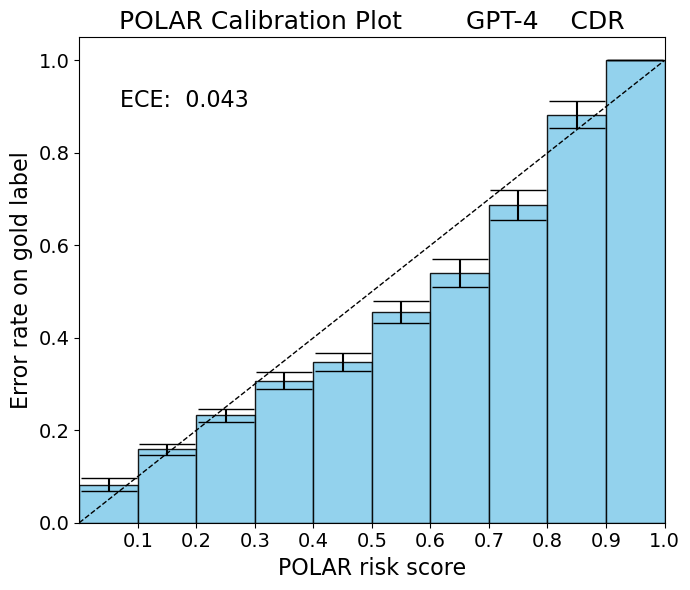

In [2]:
name = 'cdr'
gpt_model = 'gpt-4'
fold = 'test'
version = ''

X, Y, weak_labels, harmonizer = match_harmonizer(name, gpt_model, fold=fold, version=version)

errors, mean_error, std_error, ECE = harmonizer.calibration_bar(weak_labels, Y['test'])

x_pos = np.array(list(errors))

# Create the bar plot
fig, ax = plt.subplots(figsize=(7,6))  # Size of the plot

ax.bar(x_pos, mean_error, yerr=std_error, width=1, align='center', alpha=0.9, ecolor='black', capsize=20, color='skyblue', edgecolor='black')
ax.set_ylabel('Error rate on gold label', fontsize=16)
ax.set_xlabel('POLAR risk score', fontsize=16)
ax.set_xticks(x_pos + 1 / 2)
ax.set_xticklabels([(bin+1)/10 for bin in errors])
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_title(f'POLAR Calibration Plot        {GPT_model[gpt_model]}    {Name[name]}', fontsize=18)
ax.yaxis.grid(False)
ax.text(0.2, 0.9, f'ECE: {ECE: .3f}', fontsize=16)

# Add straight dashed line
ax.plot([-0.5, 9.5], [0, 1], 'k--', linewidth=1)

ax.set_xlim([-0.5, 9.5])

# Save the figure and show
plt.tight_layout()
fig.savefig(f'Results/calibration_10_{name}_{gpt_model}.pdf')
plt.show()

BERT_square_-5_-4


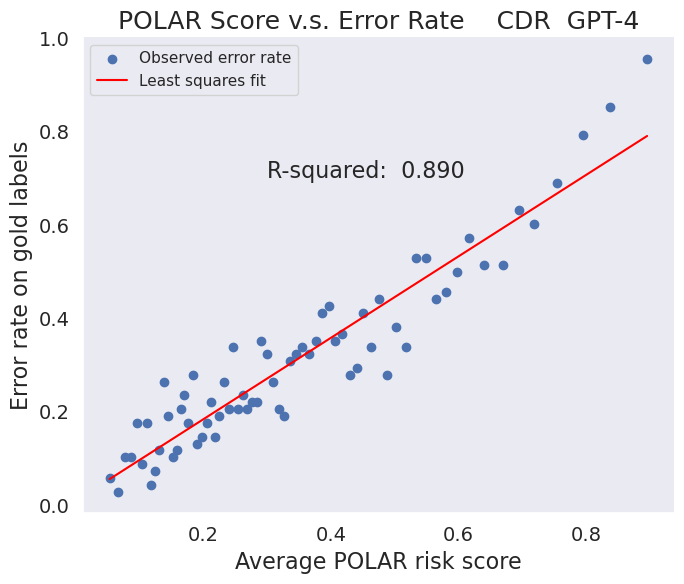

In [3]:
name = 'cdr'
gpt_model = 'gpt-4'
fold = 'test'
version = ''

X, Y, weak_labels, harmonizer = match_harmonizer(name, gpt_model, fold=fold, version=version)

error_rate_bin, doubt_score_bin, _ = harmonizer.correlation_scatter(weak_labels, Y['test'])

import seaborn as sns

# Set a seaborn theme and color palette
sns.set_theme(style="darkgrid")
sns.set_palette("deep")

# Create the scatter plot
fig, ax = plt.subplots(figsize=(7,6))  # Size of the plot

ax.scatter(doubt_score_bin, error_rate_bin, label='Observed error rate')  # Scatter plot
slope, intercept, r_value, p_value, std_err = stats.linregress(doubt_score_bin, error_rate_bin)
ax.plot(doubt_score_bin, intercept + slope*np.array(doubt_score_bin), color='red', label='Least squares fit')  # Fitted line
ax.grid(False)
ax.set_xlabel('Average POLAR risk score', fontsize=16)
ax.set_ylabel('Error rate on gold labels', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.text(0.3, 0.7, f'R-squared: {r_value**2: .3f}', fontsize=16)
ax.set_title(f'POLAR Score v.s. Error Rate    {name.upper()}  {gpt_model.upper()}', fontsize=18)
ax.legend()
# Remove the top and right spines from plot
sns.despine()


# Save the figure and show
plt.tight_layout()
fig.savefig(f'Results/correlation_{name}_{gpt_model}.pdf')
plt.show()

BERT_square_-5_-4
LR_square_-5_-5
MLP_linear_-5_-5


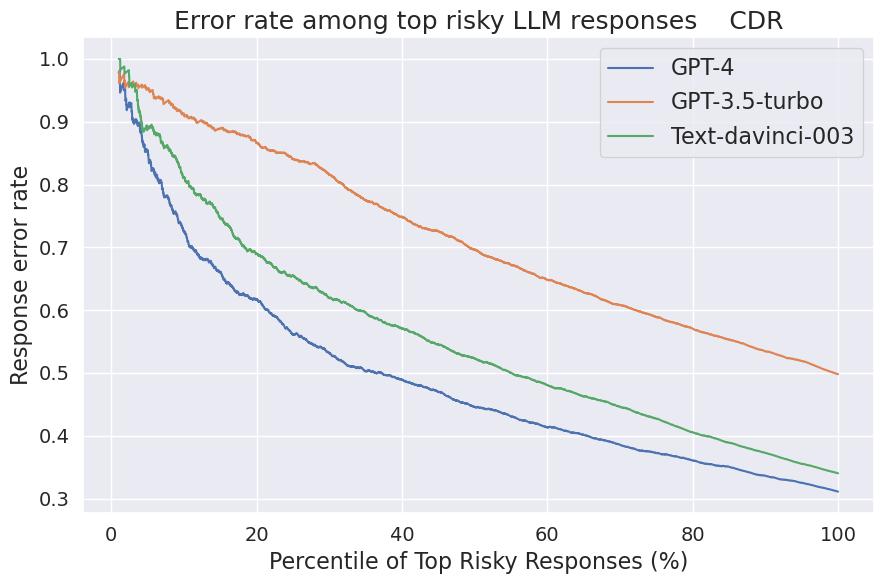

In [23]:
fig, ax = plt.subplots(figsize=(9,6))  # Size of the plot
for name in ['cdr']:
    for gpt_model in ['gpt-4', 'gpt-35-turbo', 'text-davinci-003']:
        fold = 'test'

        X, Y, weak_labels, harmonizer = match_harmonizer(name, gpt_model, fold=fold)

        doubt_scores = harmonizer.rank_doubt_scores(weak_labels)
        # The harmonizer is used to check against the weak labels and assign doubt score for each source j on each voted example.

        j = len(doubt_scores) - 1
        n = len(doubt_scores[j])
        
        error_rate = []
        h_error_rate = []
        top_L = []
        top_Y = []
        top_P = []
        top_Lex = []
        top_doubt = []
        for i in range(int(n)):
            ex = doubt_scores[j][i]
            ii = ex[1]
            top_L.append(weak_labels[ii][j])
            top_Y.append(Y[fold][ii])
            top_P.append(ex[2])
            #top_Lex.append(L_llm_[fold][ii][0])
            top_doubt.append(ex[0])
            error_rate.append((np.array(top_L)!=np.array(top_Y)).sum() / len(top_L))
            h_error_rate.append((np.array(top_P)!=np.array(top_Y)).sum() / len(top_L))
            
        top_ratio = (np.arange(len(error_rate))+1) / n
        start = int(n/100)

        plt.plot(np.array(top_ratio[start:])*100, error_rate[start:], label=GPT_model[gpt_model])
        #plt.plot(top_ratio[start:], h_error_rate[start:])
plt.xlabel('Percentile of Top Risky Responses (%)', fontsize=16)
plt.ylabel('Response error rate', fontsize=16)
plt.legend(fontsize=16)
plt.title(f'Error rate among top risky LLM responses    {Name[name]}', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)

# Save the figure and show
plt.tight_layout()
plt.savefig(f'Results/top_risk_{name}.pdf')
plt.show()

#### Dynamic Prompting

BERT_square_-5_-4


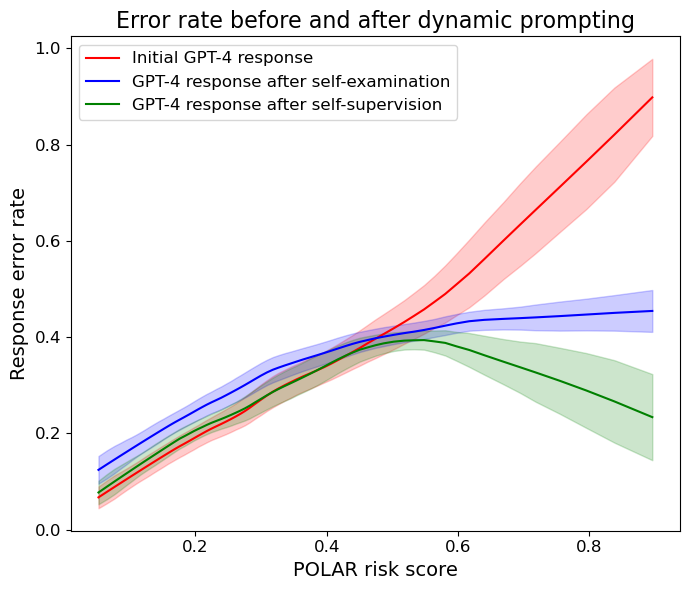

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

name = 'cdr'
gpt_model = 'gpt-4'
fold = 'test'
version = ''
X, Y, weak_labels, harmonizer = match_harmonizer(name, gpt_model, fold=fold, version=version)

new_version = 'reask'
# New LLM labels
new_LLM_labels = json.load(open(os.path.join(PATH, 'LLM_labels', gpt_model, new_version, name, 'test.json')))
error_rate_bin, doubt_score_bin, error_rate_bin_new = harmonizer.correlation_scatter(weak_labels, Y['test'], new_LLM_labels)

new_version = 'explain'
# New LLM labels
new_LLM_labels = json.load(open(os.path.join(PATH, 'LLM_labels', gpt_model, new_version, name, 'test.json')))
error_rate_bin, doubt_score_bin, error_rate_bin_new2 = harmonizer.correlation_scatter(weak_labels, Y['test'], new_LLM_labels)

# Sample data
x = np.array(doubt_score_bin)
y = np.array(error_rate_bin)
# Calculate lowess smooth
ys = lowess(y, x, frac=0.5)[:, 1]
xs = lowess(y, x, frac=0.5)[:, 0]
# Bootstrap to estimate the 95% confidence intervals
n_bootstraps = 1000
bootstrap_ys = np.zeros((n_bootstraps, len(x)))
for i in range(n_bootstraps):
    sample_index = np.random.choice(range(len(x)), len(x), replace=True)
    bootstrap_ys[i, :] = lowess(y[sample_index], x[sample_index], frac=0.5)[:, 1]
lower_bound = np.percentile(bootstrap_ys, 2.5, axis=0)
upper_bound = np.percentile(bootstrap_ys, 97.5, axis=0)
lower_bound = ys + np.std(bootstrap_ys, axis=0)
upper_bound = ys - np.std(bootstrap_ys, axis=0)


y_new = np.array(error_rate_bin_new)
# Calculate lowess smooth
ys_new = lowess(y_new, x, frac=0.5)[:, 1]
# Bootstrap to estimate the 95% confidence intervals
n_bootstraps = 1000
bootstrap_ys_new = np.zeros((n_bootstraps, len(x)))
for i in range(n_bootstraps):
    sample_index = np.random.choice(range(len(x)), len(x), replace=True)
    bootstrap_ys_new[i, :] = lowess(y_new[sample_index], x[sample_index], frac=0.5)[:, 1]
lower_bound_new = ys_new + np.std(bootstrap_ys_new, axis=0)
upper_bound_new = ys_new - np.std(bootstrap_ys_new, axis=0)

y_new2 = np.array(error_rate_bin_new2)
# Calculate lowess smooth
ys_new2 = lowess(y_new2, x, frac=0.5)[:, 1]
# Bootstrap to estimate the 95% confidence intervals
n_bootstraps = 1000
bootstrap_ys_new2 = np.zeros((n_bootstraps, len(x)))
for i in range(n_bootstraps):
    sample_index = np.random.choice(range(len(x)), len(x), replace=True)
    bootstrap_ys_new2[i, :] = lowess(y_new2[sample_index], x[sample_index], frac=0.5)[:, 1]
lower_bound_new2 = ys_new2 + np.std(bootstrap_ys_new2, axis=0)
upper_bound_new2 = ys_new2 - np.std(bootstrap_ys_new2, axis=0)

# Create the scatter plot
fig, ax = plt.subplots(figsize=(7, 6))  # Size of the plot

#ax.scatter(x, y, label='Data points')  # Scatter plot
ax.plot(xs, ys, color='red', label='Initial GPT-4 response')  # Smoothed line
# Plot the error range
ax.fill_between(xs, lower_bound, upper_bound, color='red', alpha=0.2)


#ax.scatter(x, y_new, label='Data points')  # Scatter plot
ax.plot(xs, ys_new, color='blue', label='GPT-4 response after self-examination')  # Smoothed line
# Plot the error range
ax.fill_between(xs, lower_bound_new, upper_bound_new, color='blue', alpha=0.2)

#ax.scatter(x, y_new, label='Data points')  # Scatter plot
ax.plot(xs, ys_new2, color='green', label='GPT-4 response after self-supervision')  # Smoothed line
# Plot the error range
ax.fill_between(xs, lower_bound_new2, upper_bound_new2, color='green', alpha=0.2)

ax.set_xlabel('POLAR risk score', fontsize=14)
ax.set_ylabel('Response error rate', fontsize=14)
ax.set_title('Error rate before and after dynamic prompting', fontsize=16)
ax.legend(loc='upper left', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
# Remove the grid lines
ax.grid(False)

# Save the figure and show
plt.tight_layout()
plt.savefig(f'Results/error_curve_compare.pdf')
plt.show()

BERT_square_-5_-4
BERT_square_-5_-4
BERT_square_-5_-4
LR_square_-5_-5
LR_square_-5_-5
LR_square_-5_-5


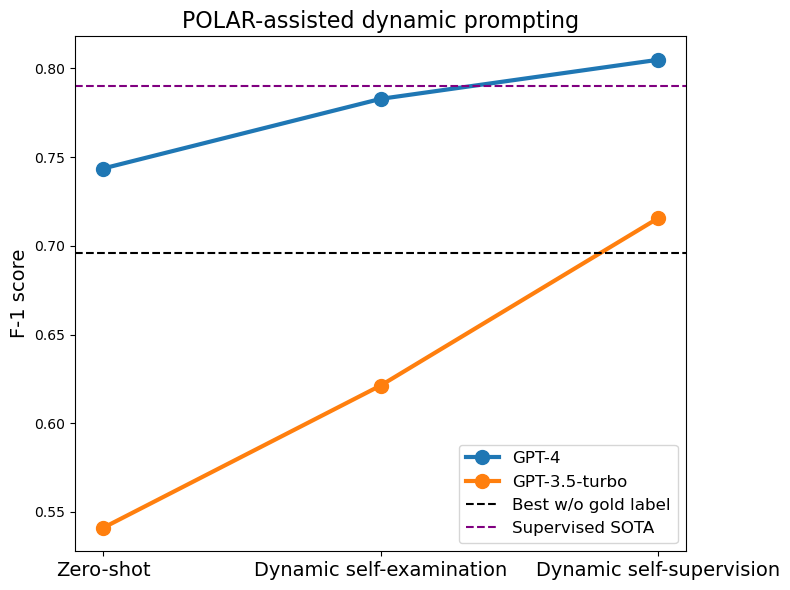

In [22]:
from sklearn.metrics import precision_recall_fscore_support

def get_combined_LLM_f1(gpt_model, new_version, threshold=0.5):
    X, Y, weak_labels, harmonizer = match_harmonizer('cdr', gpt_model, fold=fold)
    doubt_scores = harmonizer.rank_doubt_scores(weak_labels)
    j = len(doubt_scores) - 1

    new_LLM_labels = json.load(open(os.path.join(PATH, 'LLM_labels', gpt_model, new_version, name, 'test.json')))
    combined_LLM_labels = [0 for _ in range(len(Y[fold]))]
    for ex in doubt_scores[j]:
        ii = ex[1]
        if ex[0] > threshold:
            combined_LLM_labels[ii] = new_LLM_labels[ii][0]
        else:
            combined_LLM_labels[ii] = weak_labels[ii][j]
    index = np.array(combined_LLM_labels) >= 0
    return precision_recall_fscore_support(np.array(Y[fold])[index], np.array(combined_LLM_labels)[index])[2][0]


gpt_4 = [get_combined_LLM_f1('gpt-4', new_version='reask', threshold=1),
         get_combined_LLM_f1('gpt-4', new_version='reask', threshold=0.5),
         get_combined_LLM_f1('gpt-4', new_version='explain0', threshold=0.5)]
gpt_35 = [get_combined_LLM_f1('gpt-35-turbo', new_version='reask', threshold=1),
         get_combined_LLM_f1('gpt-35-turbo', new_version='reask', threshold=0.5),
         get_combined_LLM_f1('gpt-35-turbo', new_version='explain0', threshold=0.5)]


# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))  # Size of the plot

# Plot the line chart with large dots at each point
#ax.plot([1,2,3], gpt_4, marker='o', markersize=10, linestyle='-', linewidth=3, label='GPT-4')
ax.plot([1,2,3], gpt_4, marker='o', markersize=10, linestyle='-', linewidth=3, label='GPT-4')
#ax.axhline(y=get_combined_LLM_f1('gpt-4', new_version='auto_few-shot', threshold=0), 
#           linestyle='--', label='GPT-4 POLAR-sampled few-shot')

ax.plot([1,2,3], gpt_35, marker='o', markersize=10, linestyle='-', linewidth=3, label='GPT-3.5-turbo')

# Plot the benchmark line
ax.axhline(y=0.6961, linestyle='--', color='black', label='Best w/o gold label')
ax.axhline(y=0.79, linestyle='--', color='purple', label='Supervised SOTA')


# Change the x-ticks to display categorical text
ax.set_xticks([1,2,3])
ax.set_xticklabels(['Zero-shot', 'Dynamic self-examination', 'Dynamic self-supervision'], fontsize=14)

ax.set_ylabel('F-1 score', fontsize=14)
ax.set_title('POLAR-assisted dynamic prompting', fontsize=16)
ax.legend(loc='lower right', fontsize=12)
#ax.tick_params(axis='both', which='major', labelsize=14)
# Remove the grid lines
ax.grid(False)

# Save the figure and show
plt.tight_layout()
plt.savefig(f'Results/dynamic_prompt.pdf')
plt.show()

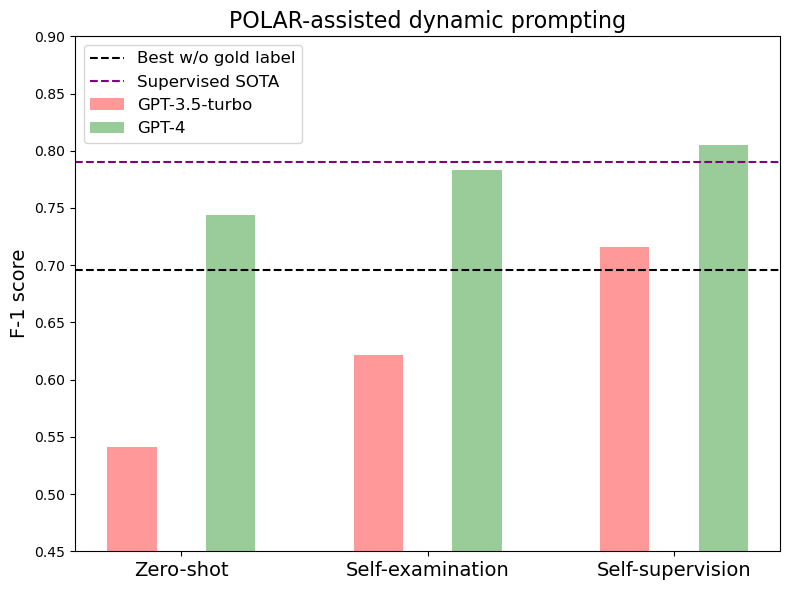

In [23]:
# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))  # Size of the plot


# Plot the benchmark line
ax.axhline(y=0.6961, linestyle='--', color='black', label='Best w/o gold label')
ax.axhline(y=0.79, linestyle='--', color='purple', label='Supervised SOTA')

index = np.array([1,2,3])
bar_width = 0.2
opacity = 0.4
error_config = {'ecolor': '0.3'}

rects2 = plt.bar(index - bar_width, gpt_35, bar_width,
                 alpha=opacity,
                 color='r',
                 error_kw=error_config,
                 label='GPT-3.5-turbo')

rects3 = plt.bar(index + bar_width, gpt_4, bar_width,
                 alpha=opacity,
                 color='g',
                 error_kw=error_config,
                 label='GPT-4')
ax.set_ylim([0.45,0.9])
plt.ylabel('F-1 score', fontsize=14)
ax.set_title('POLAR-assisted dynamic prompting', fontsize=16)
plt.xticks(index, ['Zero-shot', 'Self-examination', 'Self-supervision'], fontsize=14)
plt.legend(loc='upper left', fontsize=12)

# Save the figure and show
plt.tight_layout()
plt.savefig(f'Results/dynamic_prompt_bar.pdf')
plt.show()

### Tabels

##### Compare harmonizer model types and loss aggregation functions

In [3]:
loss_aggr_tabel = pd.DataFrame(index=['BERT', 'MLP', 'LR'], 
                         columns=pd.MultiIndex.from_product(
    [['linear', 'square', '2-norm', 'max'], ['ECE', 'R2']]))
for loss_aggr in ['linear', 'square', '2-norm', 'max']:
    for model_type in ['BERT', 'MLP', 'LR']:
        ECE_table = pd.DataFrame(index=['cdr', 'chemprot', 'semeval', 'sms'], 
                                columns=['gpt-4', 'gpt-35-turbo', 'text-davinci-003'])
        R2_table = pd.DataFrame(index=['cdr', 'chemprot', 'semeval', 'sms'], 
                                columns=['gpt-4', 'gpt-35-turbo', 'text-davinci-003'])
        for name in ['cdr', 'chemprot', 'semeval', 'sms']:
            for gpt_model in ['gpt-4', 'gpt-35-turbo', 'text-davinci-003']:
                fold = 'test'

                X, Y, weak_labels, harmonizer = match_harmonizer(name, gpt_model, fold=fold, 
                                                                version='', model_type=model_type, loss_aggr=loss_aggr)

                errors, mean_error, std_error, ECE = harmonizer.calibration_bar(weak_labels, Y[fold])
                ECE_table.loc[name][gpt_model] = ECE

                error_rate_bin, doubt_score_bin, error_rate_bin_new = harmonizer.correlation_scatter(weak_labels, Y[fold])
                R2_table.loc[name][gpt_model] = np.corrcoef(error_rate_bin, doubt_score_bin)[0,1]**2

        loss_aggr_tabel.loc[model_type, (loss_aggr, 'ECE')] = ECE_table.mean().values.mean()
        loss_aggr_tabel.loc[model_type, (loss_aggr, 'R2')] = R2_table.mean().values.mean()

BERT_linear_-6_-4
BERT_linear_-5_-5
BERT_linear_-5_-5
BERT_linear_-6_-5
BERT_linear_-5_-5
BERT_linear_-5_-5
BERT_linear_-6_-5
BERT_linear_-5_-5
BERT_linear_-5_-5
BERT_linear_-6_-5
BERT_linear_-6_-5
BERT_linear_-6_-4
MLP_linear_-6_-4
MLP_linear_-5_-5
MLP_linear_-5_-5
MLP_linear_-4_-5
MLP_linear_-4_-5
MLP_linear_-4_-5
MLP_linear_-4_-4
MLP_linear_-5_-5
MLP_linear_-4_-5
MLP_linear_-4_-5
MLP_linear_-4_-4
MLP_linear_-4_-5
LR_linear_-4_-5
LR_linear_-4_-4
LR_linear_-5_-5
LR_linear_-4_-4
LR_linear_-4_-5
LR_linear_-4_-5
LR_linear_-4_-5
LR_linear_-4_-5
LR_linear_-4_-5
LR_linear_-3_-5
LR_linear_-4_-4
LR_linear_-3_-4
BERT_square_-5_-4
BERT_square_-5_-5
BERT_square_-5_-5
BERT_square_-6_-4
BERT_square_-5_-5
BERT_square_-5_-5
BERT_square_-4_-4
BERT_square_-5_-5
BERT_square_-4_-5
BERT_square_-5_-4
BERT_square_-5_-5
BERT_square_-5_-4
MLP_square_-6_-5
MLP_square_-5_-5
MLP_square_-5_-5
MLP_square_-4_-4
MLP_square_-4_-5
MLP_square_-4_-5
MLP_square_-4_-5
MLP_square_-4_-5
MLP_square_-4_-5
MLP_square_-3_-5
ML

(             gpt-4 gpt-35-turbo text-davinci-003
 cdr       0.126988      0.03531         0.077366
 chemprot  0.152621     0.130527         0.123211
 semeval   0.151694     0.067565         0.045637
 sms       0.026163     0.148394         0.051535,
              gpt-4 gpt-35-turbo text-davinci-003
 cdr       0.814658     0.610356         0.889874
 chemprot  0.868875     0.898062         0.905634
 semeval   0.826491     0.960274         0.958475
 sms       0.966248     0.950596         0.926155)

In [4]:
loss_aggr_tabel

linear              square              2-norm                 max  \
           ECE        R2       ECE        R2       ECE        R2       ECE   
BERT  0.062509  0.927292  0.045806  0.936623  0.054935  0.900285  0.071111   
MLP   0.055473  0.939167  0.097371  0.918836   0.06907  0.930203  0.077544   
LR    0.064054  0.935978  0.107192  0.902047  0.076603  0.928811  0.094751   

                
            R2  
BERT  0.825966  
MLP   0.893351  
LR    0.881308

In [7]:
print(loss_aggr_tabel.to_latex(float_format="{:.4f}".format))

\begin{tabular}{lllllllll}
\toprule
{} & \multicolumn{2}{l}{linear} & \multicolumn{2}{l}{square} & \multicolumn{2}{l}{2-norm} & \multicolumn{2}{l}{max} \\
{} &    ECE &     R2 &    ECE &     R2 &    ECE &     R2 &    ECE &     R2 \\
\midrule
BERT & 0.0625 & 0.9273 & 0.0458 & 0.9366 & 0.0549 & 0.9003 & 0.0711 & 0.8260 \\
MLP  & 0.0555 & 0.9392 & 0.0974 & 0.9188 & 0.0691 & 0.9302 & 0.0775 & 0.8934 \\
LR   & 0.0641 & 0.9360 & 0.1072 & 0.9020 & 0.0766 & 0.9288 & 0.0948 & 0.8813 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_26613/2183942192.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(loss_aggr_tabel.to_latex(float_format="{:.4f}".format))


##### Main POLAR result

In [ ]:
ECE_table = pd.DataFrame(index=['cdr', 'chemprot', 'semeval', 'sms'], 
                                columns=['gpt-4', 'gpt-35-turbo', 'text-davinci-003'])
R2_table = pd.DataFrame(index=['cdr', 'chemprot', 'semeval', 'sms'], 
                        columns=['gpt-4', 'gpt-35-turbo', 'text-davinci-003'])
for name in ['cdr', 'chemprot', 'semeval', 'sms']:
    for gpt_model in ['gpt-4', 'gpt-35-turbo', 'text-davinci-003']:
        fold = 'test'

        X, Y, weak_labels, harmonizer = match_harmonizer(name, gpt_model, fold=fold, 
                                                        version='', model_type='BERT', loss_aggr='square')

        errors, mean_error, std_error, ECE = harmonizer.calibration_bar(weak_labels, Y[fold])
        ECE_table.loc[name][gpt_model] = ECE

        error_rate_bin, doubt_score_bin, error_rate_bin_new = harmonizer.correlation_scatter(weak_labels, Y[fold])
        R2_table.loc[name][gpt_model] = np.corrcoef(error_rate_bin, doubt_score_bin)[0,1]**2


#### Benchmark methods

##### Snorkel

In [5]:
from snorkel.labeling.model.label_model import LabelModel

ECE_table_sn = pd.DataFrame(index=['cdr', 'chemprot', 'semeval', 'sms'], 
                         columns=['gpt-4', 'gpt-35-turbo', 'text-davinci-003'])

R2_table_sn = pd.DataFrame(index=['cdr', 'chemprot', 'semeval', 'sms'], 
                         columns=['gpt-4', 'gpt-35-turbo', 'text-davinci-003'])
for name in ['cdr', 'chemprot', 'semeval', 'sms']:
    for gpt_model in ['gpt-4', 'gpt-35-turbo', 'text-davinci-003']:
        fold = 'test'

        X, Y, weak_labels, harmonizer = match_harmonizer(name, gpt_model, fold=fold, model_type='LR',loss_aggr='linear')
        X, Y, weak_labels_train, harmonizer = match_harmonizer(name, gpt_model, fold='train', model_type='LR',loss_aggr='linear')
        n_class =  harmonizer.probas.shape[1]
        sn = LabelModel(verbose=False, cardinality=max(2, n_class))
        sn.fit(np.array(weak_labels_train))
        P_pred = sn.predict_proba(np.array(weak_labels))

        if n_class <= 2:
            harmonizer_sn = Harmonizer(P_pred[:,1])
        else:
            harmonizer_sn = Harmonizer(P_pred)

        errors, mean_error, std_error, ECE = harmonizer_sn.calibration_bar(weak_labels, Y[fold])
        ECE_table_sn.loc[name][gpt_model] = ECE

        error_rate_bin, doubt_score_bin, error_rate_bin_new = harmonizer_sn.correlation_scatter(weak_labels, Y[fold])
        R2_table_sn.loc[name][gpt_model] = np.corrcoef(error_rate_bin, doubt_score_bin)[0,1]**2

ECE_table_sn, R2_table_sn

LR_linear_-4_-5
LR_linear_-4_-5


100%|██████████| 100/100 [00:00<00:00, 539.57epoch/s]


LR_linear_-4_-4
LR_linear_-4_-4


100%|██████████| 100/100 [00:00<00:00, 527.33epoch/s]


LR_linear_-5_-5
LR_linear_-5_-5


100%|██████████| 100/100 [00:00<00:00, 831.08epoch/s]


LR_linear_-4_-4
LR_linear_-4_-4


100%|██████████| 100/100 [00:00<00:00, 180.44epoch/s]


LR_linear_-4_-5
LR_linear_-4_-5


100%|██████████| 100/100 [00:00<00:00, 223.98epoch/s]


LR_linear_-4_-5
LR_linear_-4_-5


100%|██████████| 100/100 [00:00<00:00, 447.17epoch/s]


LR_linear_-4_-5
LR_linear_-4_-5


100%|██████████| 100/100 [00:03<00:00, 32.69epoch/s]


LR_linear_-4_-5
LR_linear_-4_-5


100%|██████████| 100/100 [00:03<00:00, 26.69epoch/s]


LR_linear_-4_-5
LR_linear_-4_-5


100%|██████████| 100/100 [00:03<00:00, 28.96epoch/s]


LR_linear_-3_-5
LR_linear_-3_-5


100%|██████████| 100/100 [00:00<00:00, 295.50epoch/s]


LR_linear_-4_-4
LR_linear_-4_-4


100%|██████████| 100/100 [00:00<00:00, 549.43epoch/s]


LR_linear_-3_-4
LR_linear_-3_-4


100%|██████████| 100/100 [00:00<00:00, 385.20epoch/s]


(             gpt-4 gpt-35-turbo text-davinci-003
 cdr       0.166934     0.164161         0.153634
 chemprot  0.182368      0.22833          0.21762
 semeval   0.068298      0.14977         0.118626
 sms       0.243491     0.075347         0.200647,
              gpt-4 gpt-35-turbo text-davinci-003
 cdr       0.299039     0.320009         0.370508
 chemprot  0.510209     0.625331         0.699499
 semeval   0.713992     0.821161         0.796178
 sms       0.088702     0.202061          0.05284)

##### Majority Vote

In [6]:
from snorkel.labeling.model import MajorityLabelVoter

ECE_table_mv = pd.DataFrame(index=['cdr', 'chemprot', 'semeval', 'sms'], 
                         columns=['gpt-4', 'gpt-35-turbo', 'text-davinci-003'])
R2_table_mv = pd.DataFrame(index=['cdr', 'chemprot', 'semeval', 'sms'], 
                         columns=['gpt-4', 'gpt-35-turbo', 'text-davinci-003'])
for name in ['cdr', 'chemprot', 'semeval', 'sms']:
    for gpt_model in ['gpt-4', 'gpt-35-turbo', 'text-davinci-003']:
        fold = 'test'

        X, Y, weak_labels, harmonizer = match_harmonizer(name, gpt_model, fold=fold, model_type='',loss_aggr='linear')
        #X, Y, weak_labels_train, harmonizer = match_harmonizer(name, gpt_model, fold='train', model_type='LR',loss_aggr='linear')
        n_class =  harmonizer.probas.shape[1]
        sn = MajorityLabelVoter(verbose=False, cardinality=max(2, n_class))
        P_pred = sn.predict_proba(np.array(weak_labels))

        if n_class <= 2:
            harmonizer_mv = Harmonizer(P_pred[:,1])
        else:
            harmonizer_mv = Harmonizer(P_pred)

        errors, mean_error, std_error, ECE = harmonizer_mv.calibration_bar(weak_labels, Y[fold])
        ECE_table_mv.loc[name][gpt_model] = ECE

        error_rate_bin, doubt_score_bin, error_rate_bin_new = harmonizer_mv.correlation_scatter(weak_labels, Y[fold])
        R2_table_mv.loc[name][gpt_model] = np.corrcoef(error_rate_bin, doubt_score_bin)[0,1]**2

ECE_table_mv, R2_table_mv

LR_linear_-4_-5
LR_linear_-4_-4
MLP_linear_-5_-5
MLP_linear_-4_-5
MLP_linear_-4_-5
MLP_linear_-4_-5
BERT_linear_-6_-5
BERT_linear_-5_-5
BERT_linear_-5_-5
MLP_linear_-4_-5
BERT_linear_-6_-5
LR_linear_-3_-4


(             gpt-4 gpt-35-turbo text-davinci-003
 cdr       0.144958     0.181703          0.14916
 chemprot  0.233431     0.282246         0.279372
 semeval   0.114525     0.277263          0.24173
 sms       0.588235     0.148148            0.325,
              gpt-4 gpt-35-turbo text-davinci-003
 cdr       0.348152     0.539492         0.449911
 chemprot  0.243921     0.030691         0.306848
 semeval   0.378501     0.208107         0.396115
 sms       0.091429     0.006239         0.090909)

##### LLM distilled

In [7]:
ECE_table_dist = pd.DataFrame(index=['cdr', 'chemprot', 'semeval', 'sms'], 
                         columns=['gpt-4', 'gpt-35-turbo', 'text-davinci-003'])
R2_table_dist = pd.DataFrame(index=['cdr', 'chemprot', 'semeval', 'sms'], 
                         columns=['gpt-4', 'gpt-35-turbo', 'text-davinci-003'])
for name in ['cdr', 'chemprot', 'semeval', 'sms']:
    for gpt_model in ['gpt-4', 'gpt-35-turbo', 'text-davinci-003']:
        fold = 'test'

        X, Y, weak_labels, harmonizer = match_harmonizer(name, gpt_model, fold=fold, version='_LLMs/'+gpt_model, model_type='BERT')

        errors, mean_error, std_error, ECE = harmonizer.calibration_bar(weak_labels, Y[fold])
        ECE_table_dist.loc[name][gpt_model] = ECE

        error_rate_bin, doubt_score_bin, error_rate_bin_new = harmonizer.correlation_scatter(weak_labels, Y[fold])
        R2_table_dist.loc[name][gpt_model] = np.corrcoef(error_rate_bin, doubt_score_bin)[0,1]**2
ECE_table_dist, R2_table_dist

BERT_linear_-6_-4
BERT_linear_-6_-5
BERT_linear_-6_-4
BERT_linear_-6_-5
BERT_linear_-6_-5
BERT_linear_-6_-5
BERT_linear_-6_-5
BERT_linear_-6_-5
BERT_linear_-6_-5
BERT_linear_-5_-5
BERT_linear_-5_-5
BERT_linear_-5_-5


(             gpt-4 gpt-35-turbo text-davinci-003
 cdr       0.164257     0.221584         0.089248
 chemprot   0.21614     0.158961         0.196077
 semeval   0.062743     0.107794         0.064689
 sms       0.012714      0.13119         0.032843,
              gpt-4 gpt-35-turbo text-davinci-003
 cdr        0.59178     0.037087           0.8964
 chemprot   0.76628     0.844749         0.824758
 semeval   0.947045     0.757058         0.935756
 sms       0.976835     0.775443         0.955755)

In [18]:
name = 'sms'

all_res = np.array([ECE_table.loc[name].values,
                    R2_table.loc[name].values,
                    ECE_table_sn.loc[name].values,
                    R2_table_sn.loc[name].values,
                    ECE_table_mv.loc[name].values,
                    R2_table_mv.loc[name].values,
                    ECE_table_dist.loc[name].values,
                    R2_table_dist.loc[name].values])

AllTabels = pd.DataFrame(all_res.T, index=list(GPT_model), 
                         columns=pd.MultiIndex.from_product(
    [['POLAR', 'Snorkel', 'Majority vote', 'LLM distilled'], ['ECE', 'R2']]))

AllTabels

POLAR             Snorkel           Majority vote  \
                       ECE        R2       ECE        R2           ECE   
gpt-4             0.014441   0.98023  0.243491  0.088702      0.588235   
gpt-35-turbo       0.04091   0.96269  0.075347  0.202061      0.148148   
text-davinci-003  0.022861  0.942725  0.200647   0.05284         0.325   

                           LLM distilled            
                        R2           ECE        R2  
gpt-4             0.091429      0.012714  0.976835  
gpt-35-turbo      0.006239       0.13119  0.775443  
text-davinci-003  0.090909      0.032843  0.955755

In [19]:
print(AllTabels.to_latex(float_format="{:.4f}".format))

\begin{tabular}{lllllllll}
\toprule
{} & \multicolumn{2}{l}{POLAR} & \multicolumn{2}{l}{Snorkel} & \multicolumn{2}{l}{Majority vote} & \multicolumn{2}{l}{LLM distilled} \\
{} &    ECE &     R2 &     ECE &     R2 &           ECE &     R2 &           ECE &     R2 \\
\midrule
gpt-4            & 0.0144 & 0.9802 &  0.2435 & 0.0887 &        0.5882 & 0.0914 &        0.0127 & 0.9768 \\
gpt-35-turbo     & 0.0409 & 0.9627 &  0.0753 & 0.2021 &        0.1481 & 0.0062 &        0.1312 & 0.7754 \\
text-davinci-003 & 0.0229 & 0.9427 &  0.2006 & 0.0528 &        0.3250 & 0.0909 &        0.0328 & 0.9558 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_2264/2195252618.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(AllTabels.to_latex(float_format="{:.4f}".format))
